# NHANES data

> ### [Variable search](http://wwwn.cdc.gov/Nchs/Nhanes/Search/default.aspx)
> ### [Demographic data](http://wwwn.cdc.gov/Nchs/Nhanes/Search/DataPage.aspx?Component=Demographics) - [variable list](http://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Demographics)
> ### [Dietary](http://wwwn.cdc.gov/Nchs/Nhanes/Search/DataPage.aspx?Component=Dietary) - [variable list](http://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Dietary)
> ### [Examination](http://wwwn.cdc.gov/Nchs/Nhanes/Search/DataPage.aspx?Component=Examination) - [variable list](http://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Examination)
> ### [Laboratory](http://wwwn.cdc.gov/Nchs/Nhanes/Search/DataPage.aspx?Component=Laboratory) - [variable list](http://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Laboratory)
> ### [Questionnaire](http://wwwn.cdc.gov/Nchs/Nhanes/Search/DataPage.aspx?Component=Questionnaire) - [variable list](http://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Questionnaire)

# Methods

### Data source
> In this study, we used a 1999-2004 data set from the National Health and Nutrition Examination Survey (NHANES) to generate the SVM algorithm. NHANES is an ongoing, cross-sectional, probability sample survey of the U.S. population. It collects demographic, health history, and behavioral information from participants in home interviews. Participants are also invited for detailed physical, physiological, and laboratory examinations that are performed by trained personnel in specially equipped mobile centers [15].

> We limited our study to non-pregnant participants aged 20 or older. Participants were considered to have diagnosed diabetes if they answered “yes” to the question “Have you ever been told by a doctor or health professionals that you have diabetes?” Participants who answered “no” to this question but who had a measured fasting plasma glucose ≥ 126 mg/dl were considered to have undiagnosed diabetes; those with a fasting plasma glucose 100-125 mg/dl were considered to have pre-diabetes. Participants with fasting glucose <100 mg/dl were considered to not have diabetes

> We devised two different classification schemes (Table 1). In Classification Scheme I, the group of persons with diabetes (diagnosed or undiagnosed) was distinguished from those without diabetes, including persons with pre-diabetes. In Classification Scheme II, the group of persons with either undiagnosed diabetes or pre-diabetes was distinguished from those without diabetes. The models were developed using a sample of 80% of the individuals in each group and validated in the remaining 20%.

### Variable selection
> We selected 14 simple variables commonly associated with the risk for diabetes: family history, age, gender, race and ethnicity, weight, height, waist circumference, BMI, hypertension, physical activity, smoking, alcohol use, education, and household income. Variable selection was performed according to an automatic approach developed by Chen et al. [16]. The significance of the automatically selected set of variables was further manually evaluated by fine tuning parameters. The variables included in the final selection were those with the best discriminative performance.

### Table 1

<img src="./img/table1.png">

In [31]:
import os
import pandas as pd
import matplotlib.pylab as plt
from utils import fetch_NHANES

plt.style.use('ggplot')
%matplotlib inline

In [32]:
help(fetch_NHANES)

Help on function fetch_NHANES in module utils:

fetch_NHANES(year, database, data_dir='./data')
    Retrieve NHANES data as a Pandas DataFrame.
    
    Years of available data:
        1999-2000, 2001-2002, 2003-2004, 2005-2006,
        2007-2008, 2009-2010, 2011-2012, 2013-2014



In [35]:
DEMO = pd.read_csv('./data/1999-2000/DEMO.csv')
DEMO_B = pd.read_csv('./data/2001-2002/DEMO_B.csv')
DEMO_C = pd.read_csv('./data/2003-2004/DEMO_C.csv')

In [36]:
DIQ = pd.read_csv('./data/1999-2000/DIQ.csv')
DIQ_B = pd.read_csv('./data/2001-2002/DIQ_B.csv')
DIQ_C = pd.read_csv('./data/2003-2004/DIQ_C.csv')

In [37]:
LAB10AM = pd.read_csv('./data/1999-2000/LAB10AM.csv')
L10AM_B = pd.read_csv('./data/2001-2002/L10AM_B.csv')
L10AM_C = pd.read_csv('./data/2003-2004/L10AM_C.csv')

In [38]:
ALQ = pd.read_csv('./data/1999-2000/ALQ.csv')
ALQ_B = pd.read_csv('./data/2001-2002/ALQ_B.csv')
ALQ_C = pd.read_csv('./data/2003-2004/ALQ_C.csv')

In [39]:
SMQ = pd.read_csv('./data/1999-2000/SMQ.csv')
SMQ_B = pd.read_csv('./data/2001-2002/SMQ_B.csv')
SMQ_C = pd.read_csv('./data/2003-2004/SMQ_C.csv')

In [40]:
BMX = pd.read_csv('./data/1999-2000/BMX.csv')
BMX_B = pd.read_csv('./data/2001-2002/BMX_B.csv')
BMX_C = pd.read_csv('./data/2003-2004/BMX_C.csv')

In [41]:
BPQ = pd.read_csv('./data/1999-2000/BPQ.csv')
BPQ_B = pd.read_csv('./data/2001-2002/BPQ_B.csv')
BPQ_C = pd.read_csv('./data/2003-2004/BPQ_C.csv')

In [42]:
MCQ = pd.read_csv('./data/1999-2000/MCQ.csv')
MCQ_B = pd.read_csv('./data/2001-2002/MCQ_B.csv')
MCQ_C = pd.read_csv('./data/2003-2004/MCQ_C.csv')

In [43]:
PAQ = pd.read_csv('./data/1999-2000/PAQ.csv')
PAQ_B = pd.read_csv('./data/2001-2002/PAQ_B.csv')
PAQ_C = pd.read_csv('./data/2003-2004/PAQ_C.csv')

### variables of interest
```
DEMO
    age:            
                    RIDAGEYR
    gender:         
                    RIAGENDR
    race:           
                    RIDRETH1 # Race/Ethnicity - Recode
    weight:         
                    WTINT2YR # Full Sample 2 Year Interview Weight
                    WTINT4YR # Full Sample 4 Year Interview Weight
                    WTMEC2YR # Full Sample 2 Year MEC Exam Weight
                    WTMEC4YR # Full Sample 4 Year MEC Exam Weight
    education:
                    DMDEDUC2 # Education Level - Adults 20+
    house income:   
                    INDHHINC # Annual Household Income

ALQ
    alcohol use:    
                    ALQ110   # Had at least 12 alcohol drinks/lifetime?
                    // ALD100   # Had at least 12 alcohol drinks/1 yr?
                    // ALD240   # How often drink beer (per month)
    
SMQ
    smoking:        SMD130   # Age started pipe smoking regularly
                    SMD410   # Does anyone smoke in the home
                    SMQ050Q	 # How long since quit smoking cigarettes

BMX
    height:         BMXHT    # Standing Height (cm)
    waist cir:      BMXWAIST # Waist Circumference (cm)
    bmi:            BMXBMI   # Body Mass Index (kg/m**2)

BPQ
    hypertension:   BPQ020   # Ever told you had high blood pressure

PAQ
    phys act:       PAQ180   # Avg level of physical activity each day

MCQ
    family hx:      MCQ250A  # Blood relatives have diabetes
```

### Age >= 20 and non-pregnant population

In [44]:
age = 20

In [45]:
df_00 = DEMO.loc[((DEMO.RIAGENDR == 2) & (DEMO.RIDAGEYR >= age) & (DEMO.RIDEXPRG == 2)) | 
                 ((DEMO.RIAGENDR == 1) & (DEMO.RIDAGEYR >= age)),
                 ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'WTINT2YR', 'DMDEDUC2', 'INDHHINC']] \
        .merge(ALQ[['SEQN', 'ALQ110']], on='SEQN') \
        .merge(BMX[['SEQN', 'BMXHT', 'BMXWAIST', 'BMXBMI']], on='SEQN') \
        .merge(BPQ[['SEQN', 'BPQ020']], on='SEQN') \
        .merge(PAQ[['SEQN', 'PAQ180']], on='SEQN') \
        .merge(MCQ[['SEQN', 'MCQ250A']], on='SEQN')

df_00.shape

(3284, 14)

In [46]:
df_02 = DEMO_B.loc[((DEMO_B.RIAGENDR == 2) & (DEMO_B.RIDAGEYR >= age) & (DEMO_B.RIDEXPRG == 2)) | 
                   ((DEMO_B.RIAGENDR == 1) & (DEMO_B.RIDAGEYR >= age)),
                   ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'WTINT2YR', 'DMDEDUC2', 'INDHHINC']] \
        .merge(ALQ_B[['SEQN', 'ALQ110']], on='SEQN') \
        .merge(BMX_B[['SEQN', 'BMXHT', 'BMXWAIST', 'BMXBMI']], on='SEQN') \
        .merge(BPQ_B[['SEQN', 'BPQ020']], on='SEQN') \
        .merge(PAQ_B[['SEQN', 'PAQ180']], on='SEQN') \
        .merge(MCQ_B[['SEQN', 'MCQ250A']], on='SEQN')

df_02.shape

(3799, 14)

In [47]:
df_04 = DEMO_C.loc[((DEMO_C.RIAGENDR == 2) & (DEMO_C.RIDAGEYR >= age) & (DEMO_C.RIDEXPRG == 2)) | 
                   ((DEMO_C.RIAGENDR == 1) & (DEMO_C.RIDAGEYR >= age)),
                   ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'WTINT2YR', 'DMDEDUC2', 'INDHHINC']] \
        .merge(ALQ_C[['SEQN', 'ALQ110']], on='SEQN') \
        .merge(BMX_C[['SEQN', 'BMXHT', 'BMXWAIST', 'BMXBMI']], on='SEQN') \
        .merge(BPQ_C[['SEQN', 'BPQ020']], on='SEQN') \
        .merge(PAQ_C[['SEQN', 'PAQ180']], on='SEQN') \
        .merge(MCQ_C[['SEQN', 'MCQ250A']], on='SEQN')

df_04.shape

(3525, 14)

In [48]:
df_pop = pd.concat([df_00, df_02, df_04])
df_pop.shape

(10608, 14)

### Diagnosed Diabetes (total should be 1,266)

The next questions are about specific medical conditions. {Other than during pregnancy, {have you/has SP}/{Have you/Has SP}} ever been told by a doctor or health professional that {you have/{he/she/SP} has} diabetes or sugar diabetes?

In [134]:
df_00_diag = df_00.merge(DIQ.loc[DIQ.DIQ010 == 1, ['SEQN', 'DIQ010']], on="SEQN")
df_00_diag.shape

(278, 15)

In [135]:
df_02_diag = df_02.merge(DIQ_B.loc[DIQ_B.DIQ010 == 1, ['SEQN', 'DIQ010']], on="SEQN")
df_02_diag.shape

(308, 15)

In [136]:
df_04_diag = df_04.merge(DIQ_C.loc[DIQ_C.DIQ010 == 1, ['SEQN', 'DIQ010']], on="SEQN")
df_04_diag.shape

(325, 15)

In [137]:
diag_total = pd.concat([df_00_diag, df_02_diag, df_04_diag])
diag_total.loc[:,'status'] = 'diag'
diag_total.shape

(911, 16)

### Undiagnosed Diabetes (total should be 195) 

In [138]:
df_00_undiag = df_00.merge(DIQ.loc[DIQ.DIQ010 == 2, ['SEQN', 'DIQ010']] \
                           .merge(LAB10AM.loc[LAB10AM.LBXGLU >= 126, ['SEQN', 'LBXGLU']], on='SEQN'), 
                       on='SEQN')
df_00_undiag.shape

(39, 16)

In [139]:
df_02_undiag = df_02.merge(DIQ_B.loc[DIQ_B.DIQ010 == 2, ['SEQN', 'DIQ010']] \
                           .merge(L10AM_B.loc[L10AM_B.LBXGLU >= 126, ['SEQN', 'LBXGLU']], on='SEQN'), 
                        on='SEQN')
df_02_undiag.shape

(61, 16)

In [140]:
df_04_undiag = df_04.merge(DIQ_C.loc[DIQ_C.DIQ010 == 2, ['SEQN', 'DIQ010']] \
                           .merge(L10AM_C.loc[L10AM_C.LBXGLU >= 126, ['SEQN', 'LBXGLU']], on='SEQN'), 
                        on='SEQN')
df_04_undiag.shape

(38, 16)

In [141]:
undiag_total = pd.concat([df_00_undiag, df_02_undiag, df_04_undiag])
undiag_total.loc[:,'status'] = 'diag'
undiag_total.shape

(138, 17)

### Pre-diabetes (total should be 1,576)

In [142]:
df_00_prediab = df_00.merge(LAB10AM.loc[(LAB10AM.LBXGLU >= 100) & (LAB10AM.LBXGLU <= 125), ['SEQN', 'LBXGLU']],
                            on='SEQN')
df_00_prediab.shape

(426, 15)

In [143]:
df_02_prediab = df_02.merge(L10AM_B.loc[(L10AM_B.LBXGLU >= 100) & (L10AM_B.LBXGLU <= 125), ['SEQN', 'LBXGLU']],
                         on='SEQN')
df_02_prediab.shape

(554, 15)

In [144]:
df_04_prediab = df_04.merge(L10AM_C.loc[(L10AM_C.LBXGLU >= 100) & (L10AM_C.LBXGLU <= 125), ['SEQN', 'LBXGLU']], 
                         on='SEQN')
df_04_prediab.shape

(444, 15)

In [145]:
prediab_total = pd.concat([df_00_prediab, df_02_prediab, df_04_prediab])
prediab_total.loc[:,'status'] = 'nodiab'
prediab_total.shape

(1424, 16)

### No Diabetes (total should be 3,277)

In [146]:
df_00_nodiab = df_00.merge(LAB10AM.loc[LAB10AM.LBXGLU < 100, ['SEQN', 'LBXGLU']], 
                           on='SEQN')
df_00_nodiab.shape

(966, 15)

In [147]:
df_02_nodiab = df_02.merge(L10AM_B.loc[L10AM_B.LBXGLU < 100, ['SEQN', 'LBXGLU']],
                           on='SEQN')
df_02_nodiab.shape

(1077, 15)

In [148]:
df_04_nodiab = df_04.merge(L10AM_C.loc[L10AM_C.LBXGLU < 100, ['SEQN', 'LBXGLU']],
                           on='SEQN')
df_04_nodiab.shape

(999, 15)

In [149]:
nodiab_total = pd.concat([df_00_nodiab, df_02_nodiab, df_04_nodiab])
nodiab_total.loc[:,'status'] = 'nodiab'
nodiab_total.shape

(3042, 16)

### Join everything

In [150]:
df = pd.concat([diag_total, undiag_total, prediab_total, nodiab_total], ignore_index=True)
df.shape

(5515, 17)

In [151]:
df.head()
df

,ALQ110,BMXBMI,BMXHT,BMXWAIST,BPQ020,DIQ010,DMDEDUC2,INDHHINC,LBXGLU,MCQ250A,PAQ180,RIAGENDR,RIDAGEYR,RIDRETH1,SEQN,WTINT2YR,status
0,NaN,25.57,157.7,NaN,1,1,1,3,NaN,1,1,1,70,1,13,1647.446107,diag
1,NaN,36.94,174.9,130.6,1,1,3,3,NaN,1,1,1,62,3,29,42515.710172,diag
2,1,26.17,171.1,94.9,2,1,2,6,NaN,1,4,1,59,3,130,70420.818338,diag
3,NaN,29.51,168.3,110.6,2,1,3,3,NaN,9,1,1,82,4,266,6916.692889,diag
4,NaN,22.36,169.3,91.3,2,1,4,6,NaN,1,3,1,56,3,272,95894.532170,diag
5,NaN,NaN,NaN,NaN,2,1,1,12,NaN,2,1,1,85,3,360,14909.266504,diag
6,NaN,27.92,168.0,93.9,2,1,4,11,NaN,1,1,2,45,1,535,8838.541093,diag
7,2,35.92,175.4,121.7,2,1,3,8,NaN,2,2,1,69,3,655,54098.536194,diag
8,NaN,23.43,170.0,89.0,2,1,4,6,NaN,1,1,2,45,4,675,19519.870942,diag
9,NaN,37.07,170.3,121.1,2,1,4,8,NaN,2,2,1,48,1,681,25770.424595,diag


# Classification

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

In [153]:
rf = RandomForestClassifier()

In [154]:
y = df.status
X = df.drop(['status', 'SEQN', 'LBXGLU','DIQ010'], axis=1).fillna(0)

In [155]:
kf = KFold(X.shape[0], n_folds=10, shuffle=True)

In [156]:
def CV(kf, X, y):
    fold_pred = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = rf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        acc = sum(pred == y_test)/float(len(pred))
        print('Fold #{}: {}'.format(i, round(acc, 3)))
        fold_pred.append(acc)
    avg = sum(fold_pred)/len(fold_pred)
    print('AVERAGE:', round(avg, 3))

In [157]:
print('Predicting diabetes diagnosis based on')
CV(kf, X, y)

Predicting diabetes diagnosis based on
Fold #0: 0.81
Fold #1: 0.806
Fold #2: 0.79
Fold #3: 0.774
Fold #4: 0.799
Fold #5: 0.797
Fold #6: 0.795
Fold #7: 0.791
Fold #8: 0.802
Fold #9: 0.773
('AVERAGE:', 0.794)


0.77313974591651546

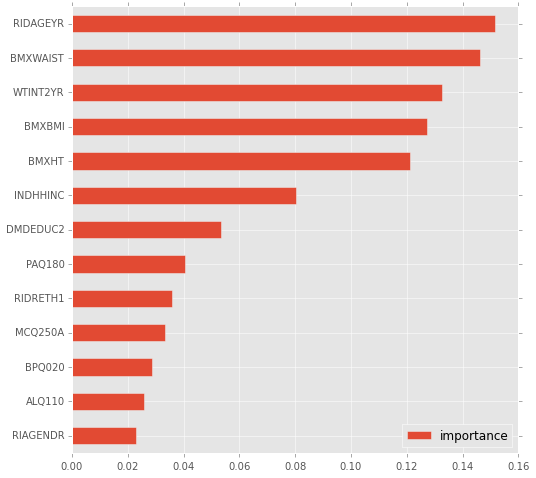

In [132]:
pd.DataFrame({'importance': rf.feature_importances_}, index=X.columns) \
     .sort_values(by='importance') \
     .plot(kind='barh', figsize=(8,8));